In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import os, math, cv2, glob, random, time
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose, LeakyReLU, Dropout


train_dataset_path = './dataset/training'
validation_dataset_path  = './dataset/validation'

# width 550 height 367
IMAGE_HEIGHT    = 64
IMAGE_WIDTH     = 64
IMAGE_SIZE      = (IMAGE_HEIGHT, IMAGE_WIDTH)

CATEGORIES      = os.listdir(train_dataset_path)
NUM_CLASSES     = len(CATEGORIES)
ALL_DATA_LENGTH = 1370
BATCH_SIZE      = 32 
EPOCHS          = 15
tf.__version__

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

'1.14.0'

In [2]:
x = np.random.choice(np.arange(ALL_DATA_LENGTH),1000)

def get_image_to_path():
    idxIn = 0; namesIn = [];
    imagesIn = np.zeros((ALL_DATA_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    for path_im in [train_dataset_path, validation_dataset_path]:
        for category in CATEGORIES:
            path = f'{path_im}/{category}/'
            class_id = CATEGORIES.index(category)
            for image in os.listdir(path):
                img = Image.open(os.path.join(path, image))
                w = img.size[0]
                h = img.size[1]
                sz = np.min((w,h))
                a=0; b=0
                if w<h: b = (h-sz)//2
                else: a = (w-sz)//2
                img = img.crop((0+a, 0+b, sz+a, sz+b))  
                img = img.resize((IMAGE_HEIGHT, IMAGE_WIDTH), Image.ANTIALIAS)   
                imagesIn[idxIn,:,:,:] = np.asarray(img)
                namesIn.append(os.path.join(path, image))
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    return imagesIn, namesIn
    
data_images, data_names = get_image_to_path()    

In [3]:
# BUILD DISCRIMINATIVE NETWORK
monkey = Input((12288,))
monkey_name = Input((1000,))
x = Dense(12288, activation='sigmoid')(monkey_name) 
x = Reshape((2,12288,1))(concatenate([monkey,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([monkey,monkey_name], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        12300288    input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                    
__________

In [4]:
# TRAINING DATA
train_y = (data_images[:1000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((1000,1000))
for i in range(1000): train_X[i,i] = 1
zeros = np.zeros((1000,12288))

# TRAIN NETWORK
lr = 0.5
for k in range(10):
    annealer = LearningRateScheduler(lambda x: lr)
    h = discriminator.fit([zeros,train_X],
                          train_y,
                          epochs=10,
                          batch_size=32,
                          callbacks=[annealer],
                          verbose=0)
    print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.5316562588214875
Epoch 20 /30 - loss = 0.531283616065979
Epoch 30 /30 - loss = 0.5311348361968994
Epoch 40 /30 - loss = 0.5310430746078492
Epoch 50 /30 - loss = 0.5309852566719055
Epoch 60 /30 - loss = 0.530947066783905
Epoch 70 /30 - loss = 0.5309204893112183
Epoch 80 /30 - loss = 0.530901388168335
Epoch 90 /30 - loss = 0.5308871088027954
Epoch 100 /30 - loss = 0.530876130104065


In [5]:
del train_X, train_y, data_images

Discriminator Recalls from Memory Monkey


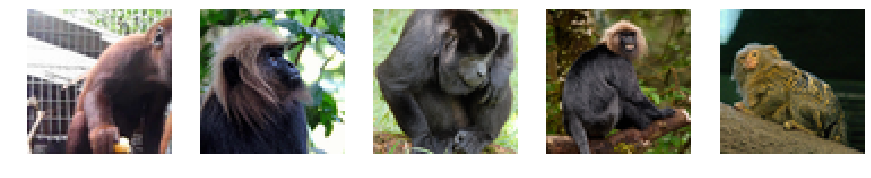

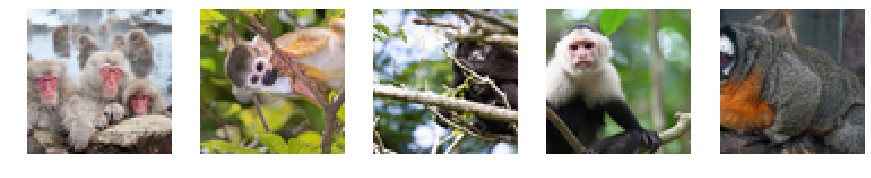

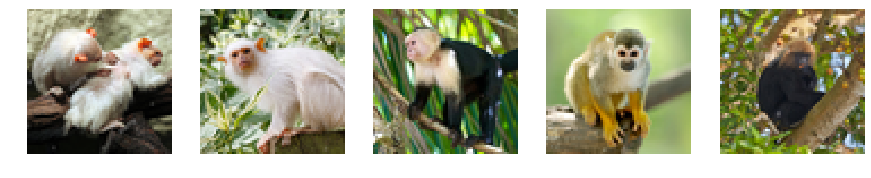

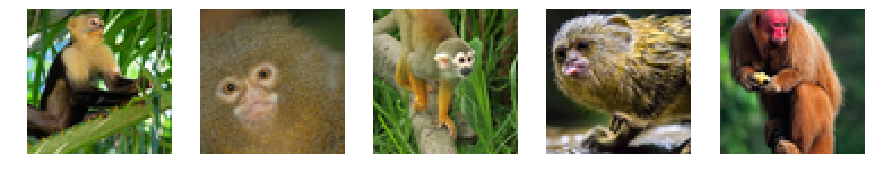

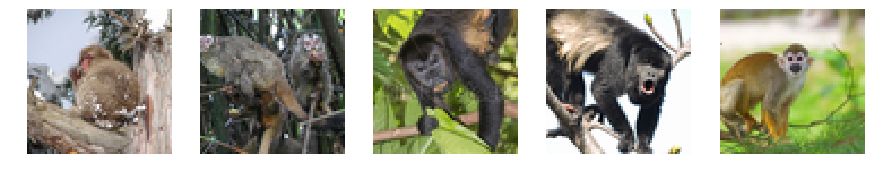

In [6]:
print('Discriminator Recalls from Memory Monkey')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((1000))
        xx[np.random.randint(1000)] = 1
        plt.subplot(1,5,j+1)
        img = discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,1000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [7]:
# BUILD GENERATOR NETWORK
BadMemory = True

if BadMemory:
    seed = Input((1000,))
    x = Dense(2048)(seed)
    x = LeakyReLU(0.2)(x)
    x = Reshape((8,8,32))(x)

    x = Conv2DTranspose(128, (3, 3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(64, (3, 3), padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2DTranspose(32, (3, 3),  padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = UpSampling2D((2, 2))(x)
    
    x = Conv2DTranspose(3, (3, 3), padding='same')(x)
    x = LeakyReLU(0.)(x)  
    generated = Flatten()(x)
else:
    seed = Input((1000,))
    x = Dense(12288)(seed)
    generated = LeakyReLU(0.2)(x)

# COMPILE
generator = Model(seed, [generated,Reshape((1000,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         2050048     input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 2048)         0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 8, 8, 32)     0           leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
conv2d_tra

In [8]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
discriminator.trainable=False    
gan_input = Input(shape=(1000,))
x = generator(gan_input)
gan_output = discriminator(x)

# COMPILE GAN
gan = Model(gan_input, gan_output)
gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE 
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 2180163     input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        12300290    model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 14,480,453
Trainable params: 2,180,163
Non-trainable params: 12,300,290
__________________________________________________________________________________________________


Epoch 1 /20 - loss = 6408.827470703125


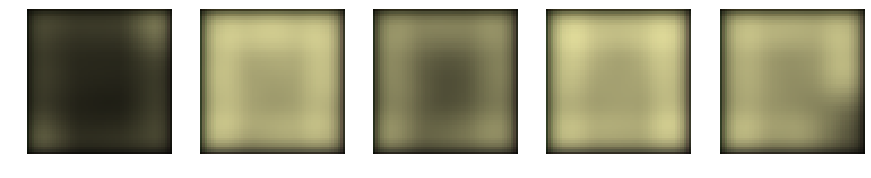

Epoch 2 /20 - loss = 2515.10706640625


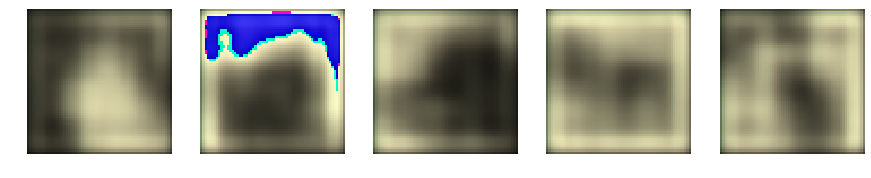

Epoch 3 /20 - loss = 1452.82712890625


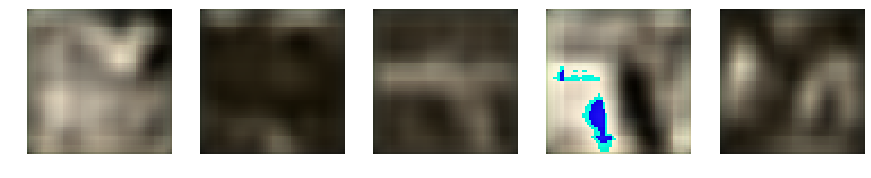

Epoch 4 /20 - loss = 869.0319677734375


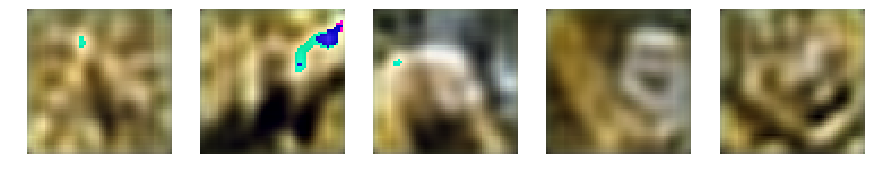

Epoch 5 /20 - loss = 610.8090356445313


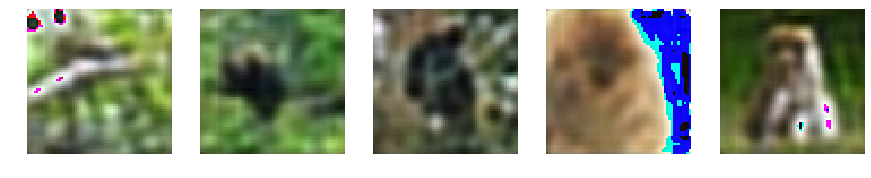

Epoch 6 /20 - loss = 478.0586049804688


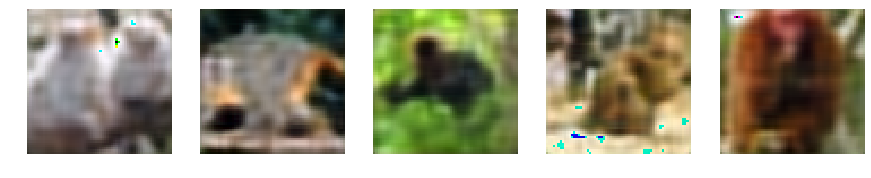

Epoch 7 /20 - loss = 359.432669921875


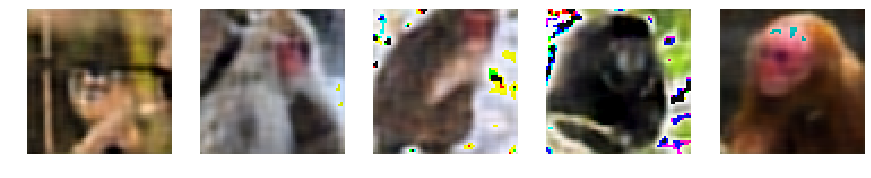

Epoch 8 /20 - loss = 278.1626806640625


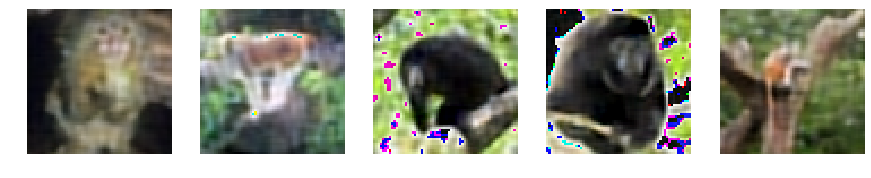

Epoch 9 /20 - loss = 197.4844278564453


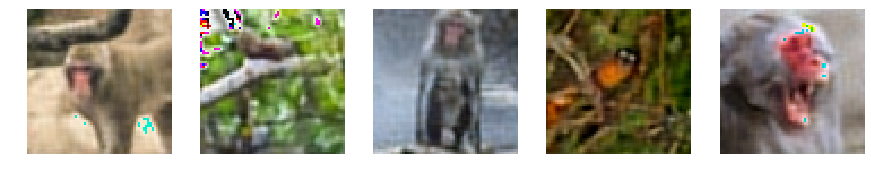

Epoch 10 /20 - loss = 162.83000946044922


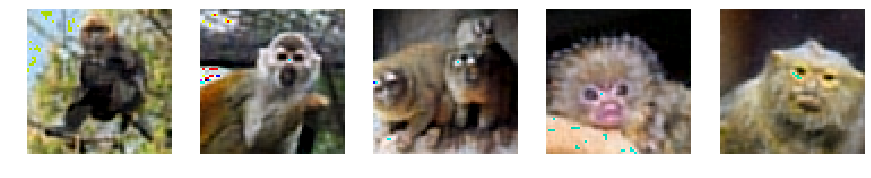

Epoch 11 /20 - loss = 142.3634168701172


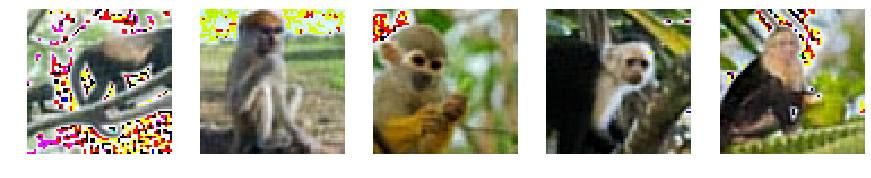

Epoch 12 /20 - loss = 132.5148446044922


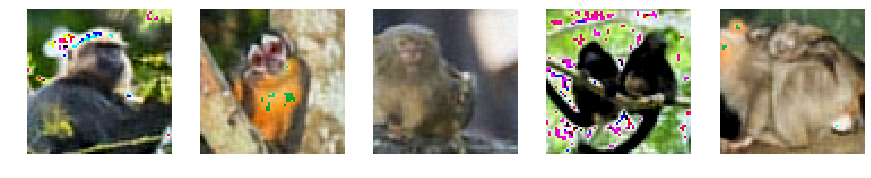

Epoch 13 /20 - loss = 126.214466796875


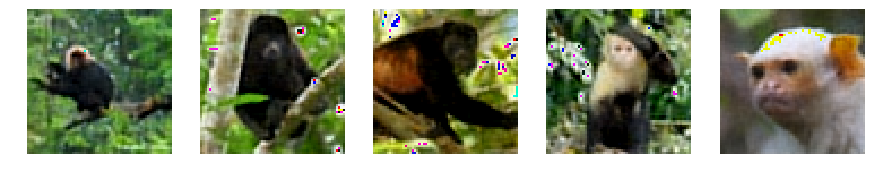

Epoch 14 /20 - loss = 112.00933557128906


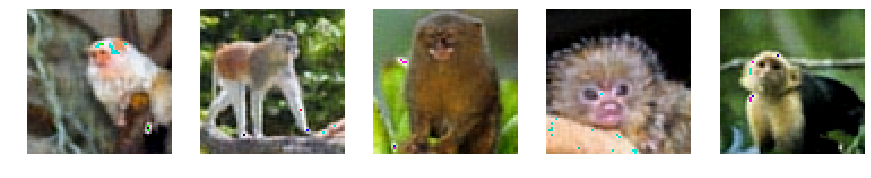

Epoch 15 /20 - loss = 113.91275109863281


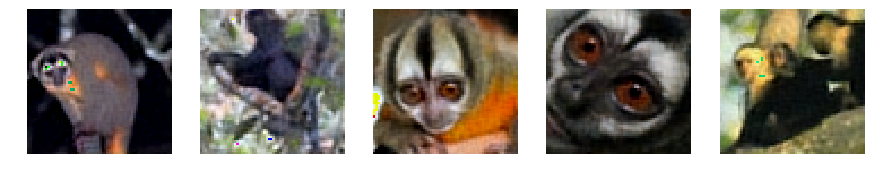

Epoch 16 /20 - loss = 120.45299072265625


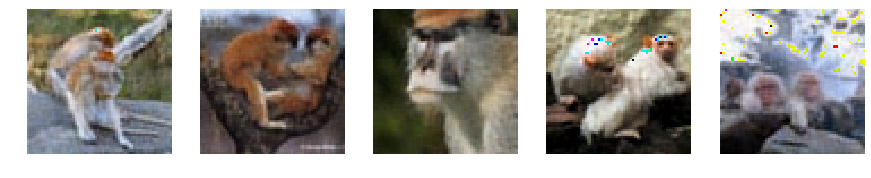

Epoch 17 /20 - loss = 102.93481030273438


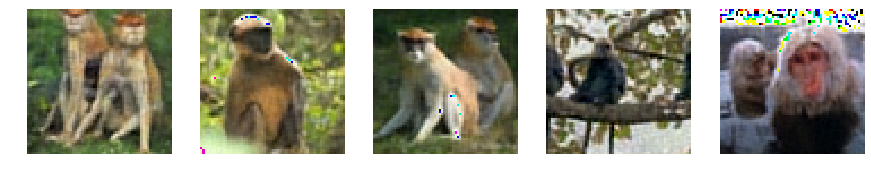

Epoch 18 /20 - loss = 98.31495721435547


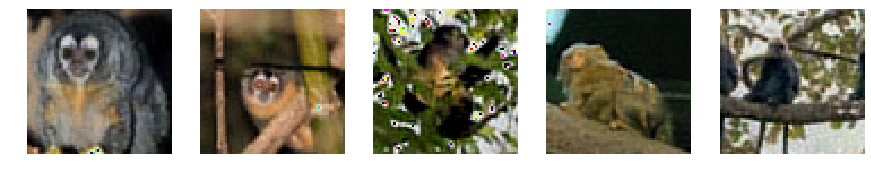

Epoch 19 /20 - loss = 99.46866278076172


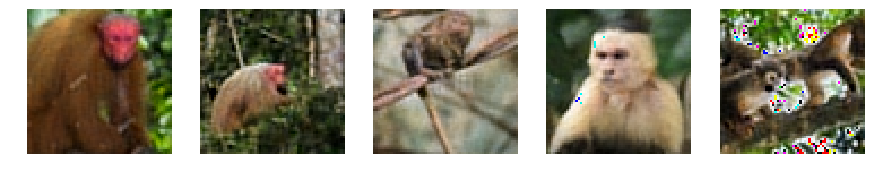

Epoch 20 /20 - loss = 94.55037841796874


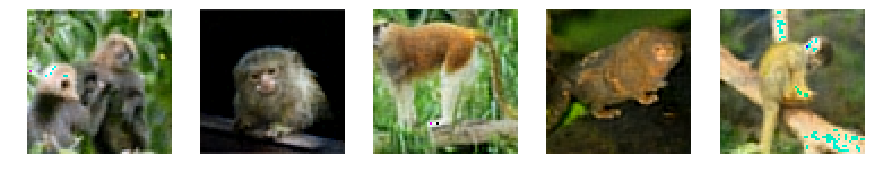

In [9]:
# TRAINING DATA
train = np.zeros((1000,1000))
for i in range(1000): train[i,i] = 1
zeros = np.zeros((1000,12288))

# TRAIN NETWORKS
ep = 1; it = 20
if BadMemory: lr = 0.005
else: lr = 5.
    
for k in range(it):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = ep, batch_size=32, callbacks=[annealer], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((1000))
        xx[np.random.randint(1000)] = 1
        plt.subplot(1,5,j+1)
        img = generator.predict(xx.reshape((-1,1000)))[0].reshape((-1,64,64,3))
        img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()  
            
    # ADJUST LEARNING RATES
    if BadMemory:
        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
    else:
        if h.history['loss'][-1] < 25: lr = 1.
        if h.history['loss'][-1] < 1.5: lr = 0.5

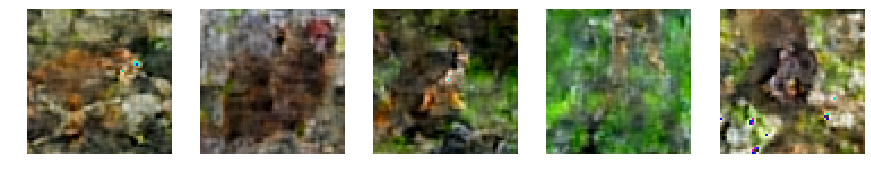

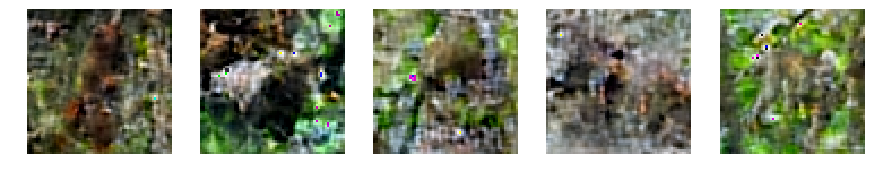

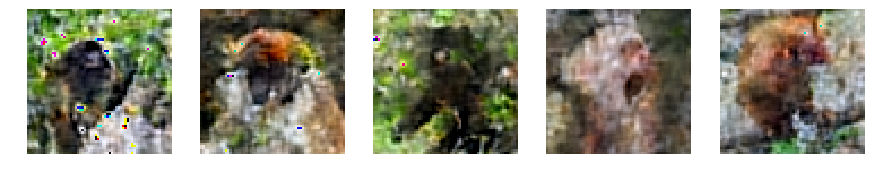

In [10]:
class MonkeyGenerator:
    index = 0   
    def getMonkey(self,seed):
        xx = np.zeros((1000))
        xx[self.index] = 0.70
        xx[np.random.randint(1000)] = 0.30
        img = generator.predict(xx.reshape((-1,1000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%1000
        return Image.fromarray( img.astype('uint8') )
    
# DISPLAY EXAMPLE DOGS
d = MonkeyGenerator()
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = d.getMonkey(np.random.normal(0,1,100))
        plt.axis('off')
        plt.imshow(img)
    plt.show() 